# Code description of Trend Following Strategy

The aim of this notebook is to describe the implementation of a trading strategy based on a trend model. This strategy is similar to the one described on the book __Trading Evolved__ in chapter 15. This trategy is there described for trading with futures, however the necessary modifications have been done in order to implement the model for trading securities.

***

## Content

- Section 0 : the strategy
- Section 1 : libraries
- Section 2 : helper functions and model settings
- Section 3 : main functions (__initialize__, __rebalance__, __analyze__)
- Section 4 : running backtest
- Section 5 : Pyfolio tear sheet

***

## Section 0 : the strategy

### Model purpose
Trend following is based on the empirical observation that prices often move in the same direction for a sustained period of time. Trend following tends to have a fairly large amount of losing trades, often as high as 70 percent. What is important however is the long term value development of the portfolio as a whole. Trend following tends to have a large amount of small losses, and a small amount of large gains.


### Investment Universe
Trend following also requires a significantly diversified portfolio, which usually translates into a significant initial capital requirement.

### Trading Frequency
The model operates on daily data and checks every day for trading signals.

### Position allocation
The position sizes taken for this model aim to take an equal amount of risk per position. For a given security, the total allocation is given by the following : $$ C = \frac{R P}{\sigma}, $$
where:
- $R =$ risk factor
- $P =$ portfolio value (marked to market)
- $\sigma =$ standard deviation of prices changes

__Important__: The value of sigma is based on the prices changes (the difference), and not on the percentage changes (quotient). The amount of days to consider is defined by the variable __vola_window__.

The value $RP$ represents the amount that we want our portfolio to change __at most__ by a single open position on an asset per day. If we divide this amount by $\sigma$ (which represents the average daily move of the asset) we basically obtain the number of shares that we are allowed to buy without surpassing our risk limits.

### Trend filter

A dual moving average is used for this model. This is used as a filter to determine the trend direction (long or short position).

We are using a combination of a slow exponential moving average (SEMA) and a faster one (FEMA). If the fast moving average is higher than the slow moving average, we determine that the trend direction is positive (bull trend). Otherwise, the trend is assumed to be negative (bear trend).

### Entry Rules

When a market hits a new day extreme (determined by the __breakdown_window__ variable) in the direction of the trend, we will enter. Recall that we have also have a trend filter, so we have to check for both conditions : 
- First check if we are on a bull trend for a given asset ( FEMA > SEMA)
- Second check if actual price is the highest on the time window defined by __breakdown_window__.

If this two conditions are satisfied, we go long on that given asset. We proceed in a symmetrical manner for a bear trend.

### Exit Rules
The exit rule here is based on this standard deviation value. For a long position this works as follows:
- As for the entry rules, we are long when we reach a new high during the __breakdown_window__ period. We store this value in memory.
- At a given day (we trade daily) we measure the standard deviation $\sigma$ on the __vola_window__ period. We define a multiplier __stop_distance__.
- We exit the market if the following condition is satisfied :

$$ \text{Current Price} < \text{Highest Price} - \text{std}*\text{stop_distance} $$.

We proceed in a symmetrical manner for a short position.

### Zipline implementation
Recall that the usual zipline backtesting implementation requires the definition of 3 functions:
- __initialize__
- __handle_data__
- __analyze__

A variation of this implementation is done when implementing the momentum strategy, since we assume we only trade at the end of each month. For this, we define the function __daily_trade__, which will replace __handle_data__. 

We then make use of a particular function provided by the zipline API : __schedule_function__. It will help us call the __daily_trade__ function at the beginning of each month.

***

## Section 1 : libraries

In [1]:
'''
Zipline dependencies
'''
import zipline
from zipline.api import symbol, set_commission, set_slippage, \
    schedule_function, date_rules, set_benchmark, \
    time_rules, order_target
from zipline.finance.commission import PerDollar
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage

'''
Pyfolio dependency
'''
import pyfolio as pf

'''
Other dependencies
'''
%matplotlib inline
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

'''
The code below is for dynamic text reporting (output displayed while running backtest)
'''
from IPython.display import display
import ipywidgets as widgets

***

## Section 2 : general settings

### Subsection 2.1 : model settings

We first define the model settings. These will be used throughout the whole simulation in order to compute several values required to carry the trading strategy.

In [105]:
"""
Model Settings
"""
starting_portfolio = 100000
risk_factor = 0.01
stop_distance = 5
breakout_window = 200
vola_window = 10
slow_ma = 20
fast_ma = 5
benchmark_symbol = 'AAPL'

"""
Commission and Slippage Settings
"""
enable_commission = True
commission_pct = 0.001
enable_slippage = True 
slippage_volume_limit = 0.2
slippage_impact = 0.1

### Subsection 2.2 : helper functions

We now define the helper functions

In [3]:
def report_result(context, data):
    '''
    Annualized return is dynamically printed at each call.
    
    Args : 
        context (zipline object)
        data (zipline object)
    
    Returns : 
        -
    
    Raises :
        -
    
    Notes :
        This is an auxilary funtion to monitor the backtest while it is running.
    '''
    context.months += 1
    today = zipline.api.get_datetime().date()
    # Calculate annualized return so far
    ann_ret = np.power(context.portfolio.portfolio_value / starting_portfolio, 
                   12 / context.months) - 1
    
    # Update the text
    out.value = """{} We have traded <b>{}</b> months 
    and the annualized return is <b>{:.2%}</b>""".format(today, context.months, ann_ret)
    
    
    
def position_size(portfolio_value, std, point_value=1.0):
    '''
    Computes risk adjusted contract allocation as a function of volatility.
    
    Args : 
        portfolio_value (float) = total portfolio value marked to market
        std (float) = standard deviation of a given asset
        point_value = size of contract (for equities is 1, for futures it depends on the underlying)
    
    Returns : 
        int = number of contracts to buy 
    
    Raises :
        -
    
    Notes :
        The portfolio is marked to market at each call
    '''    
    target_variation = portfolio_value * risk_factor
    contract_variation = std * point_value
    contracts = target_variation / contract_variation
    return int(np.nan_to_num(contracts))



***

## Section 3 : main functions

### Subsection 3.1 : initialize

In [4]:
def initialize(context):
    
    """
    Cost Settings
    """
    if enable_commission:
        comm_model = PerDollar(cost=commission_pct)
    else:
        comm_model = PerDollar(cost=0.0)
        
    set_commission(comm_model)
    
    if enable_slippage:
        slippage_model=VolumeShareSlippage(volume_limit=slippage_volume_limit, \
                                           price_impact=slippage_impact)
    else:
        slippage_model=FixedSlippage(spread=0.0)      
        
    set_slippage(slippage_model)
    
    """
    Markets to trade
    """ 
    markets = [
        "AAPL"
    ]
    
    
    
    '''    
    markets = [
        "AAPL",
        "AXP",
        "BA",
        "CAT",
        "CSCO",
        "CVX",
        "DIS",
        "GS",
        "HD",
        "IBM",
        "INTC",
        "JNJ",
        "JPM",
        "KO",
        "MCD",
        "MMM",
        "MRK",
        "MSFT",
        "NKE",
        "PFE",
        "PG",
        "TRV",
        "UNH",
        "UTX",
        "V",
        "VZ",
        "WBA",
        "WMT",
        "XOM",  
    ]
    '''
    
    # Set benchmark
    set_benchmark(symbol(benchmark_symbol))
    
    # Make a list of all continuations
    context.universe = [ symbol(market) for market in markets ]
    
    # We'll use these to keep track of best position reading
    # Used to calculate stop points.
    context.highest_in_position = {market: 0 for market in context.universe} 
    context.lowest_in_position = {market: 0 for market in context.universe}    
    
    # Schedule the daily trading
    schedule_function(daily_trade, date_rules.every_day(), time_rules.market_close())
    
    # We'll just use this for the progress output
    # during the backtest. Doesn't impact anything.
    context.months = 0    
    
    # Schedule monthly report output
    schedule_function(
        func=report_result,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open()
    )

### Subsection 3.2 : analyze

In [5]:
def analyze(context, perf):
    fig = plt.figure(figsize=(12, 8))
    
    # First chart
    ax = fig.add_subplot(311)
    ax.set_title('Strategy Results')
    ax.plot(perf['portfolio_value'], linestyle='-', 
                label='Equity Curve', linewidth=3.0)
    ax.legend()
    ax.grid(False)
    
    # Second chart
    ax = fig.add_subplot(312)
    ax.plot(perf['gross_leverage'], 
            label='Exposure', linestyle='-', linewidth=1.0)
    ax.legend()
    ax.grid(True)

    # Third chart
    ax = fig.add_subplot(313)
    ax.plot(perf['returns'], label='Returns', linestyle='-.', linewidth=1.0)
    ax.legend()
    ax.grid(True)

### Subsection 3.3 : daily_trade

The trading strategy logic is coded in this function.

In [6]:
def daily_trade(context, data):
    # Get data
    hist = data.history(
        context.universe, 
        fields=['close','volume'], 
        frequency='1d', 
        bar_count=250,
    )
    
    # Calculate trend
    hist['trend'] = hist['close'].ewm(span=fast_ma).mean() > hist['close'].ewm(span=slow_ma).mean()   
    
    # Uncheck this line to fetch information about the data
    #print(hist.xs(symbol('AAPL'), 2))
    
    # Make dictionary of open positions
    open_pos = {pos: pos for pos in context.portfolio.positions}
    
    # Iterate markets, check for trades
    for market in context.universe:
        # Slice off history for just this market
        h = hist.xs(market, 2)
        
        # Get standard deviation
        std = h.close.diff()[-vola_window:].std()        
        
        # If position is open
        if market in context.portfolio.positions:
            
            # Get position
            p = context.portfolio.positions[market]
            
            # If position is long
            if p.amount > 0:
                # First day holding the position
                if context.highest_in_position[market] == 0: 
                    context.highest_in_position[market] = p.cost_basis
                else:
                    context.highest_in_position[market] = max(
                        h['close'].iloc[-1], context.highest_in_position[market]
                    )
                    
                # Calculate stop point
                stop = context.highest_in_position[market] - (std  * stop_distance)
                
                if h.iloc[-1]['close'] < stop:
                    order_target(market, 0)
                    context.highest_in_position[market] = 0
                # Check if trend has flipped
                elif h['trend'].iloc[-1] == False:
                    order_target(market, 0)
                    context.highest_in_position[market] = 0
                    
            # If position is short
            else: 
                # First day holding the position
                if context.lowest_in_position[market] == 0: 
                    context.lowest_in_position[market] = p.cost_basis
                else:
                    context.lowest_in_position[market] = min(
                        h['close'].iloc[-1], context.lowest_in_position[market]
                    )
                
                # Calculate stop point
                stop = context.lowest_in_position[market] + (std  * stop_distance)
                
                # Check if stop is hit
                if h.iloc[-1]['close'] > stop:
                    order_target(market, 0)
                    context.lowest_in_position[market] = 0
                # Check if trend has flipped
                elif h['trend'].iloc[-1] == True:
                    order_target(market, 0)
                    context.lowest_in_position[market] = 0                         
        
        # No position on
        else:
            # Bull trend
            if h['trend'].iloc[-1]: 
                # Check if we just made a new high
                if h['close'][-1] == h[-breakout_window:]['close'].max():
                    # Compute contracts to trade
                    contracts_to_trade = position_size(context.portfolio.portfolio_value, std)
                    
                    # Limit size to 20% of avg. daily volume
                    contracts_cap = int(h['volume'][-20:].mean() * 0.2)
                    contracts_to_trade = min(contracts_to_trade, contracts_cap)
                    
                    # Place the order
                    order_target(market, contracts_to_trade)
             
            else: # Bear trend
                # Check if we just made a new low
                if h['close'][-1] == h[-breakout_window:]['close'].min():
                    # Compute contracts to trade
                    contracts_to_trade = position_size(context.portfolio.portfolio_value, std)
                    
                    # Limit size to 20% of avg. daily volume
                    contracts_cap = int(h['volume'][-20:].mean() * 0.2)
                    contracts_to_trade = min(contracts_to_trade, contracts_cap)
                    
                    # Place the order
                    order_target(market, -1 * contracts_to_trade)

***

## Section 4 : running backtest

We now run the backtest.

HTML(value='')

/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/empyrical/stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


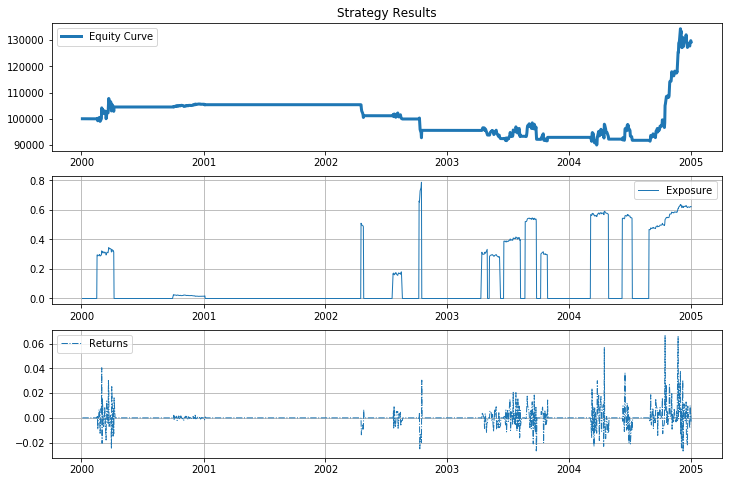

In [106]:
'''
Code to monitor backtest while running
'''
out = widgets.HTML()
display(out)

'''
Setting dates to run the backtest from
'''
start = datetime(2000, 1, 1, 8, 15, 12, 0, pytz.UTC)
end = datetime(2005, 1, 2, 8, 15, 12, 0, pytz.UTC)

'''
Running backtest
'''
perf = zipline.run_algorithm(
    start=start, end=end, 
    initialize=initialize, 
    analyze=analyze,
    capital_base=starting_portfolio,  
    data_frequency = 'daily', 
    bundle='quandl' )

***

## Section 5 : Pyfolio tear sheet

We print the returns tear sheet provided by Pyfolio. This lines of code might as well be added to the __analyze__ function to get the tear sheet be generated at the end of the backtest.

/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


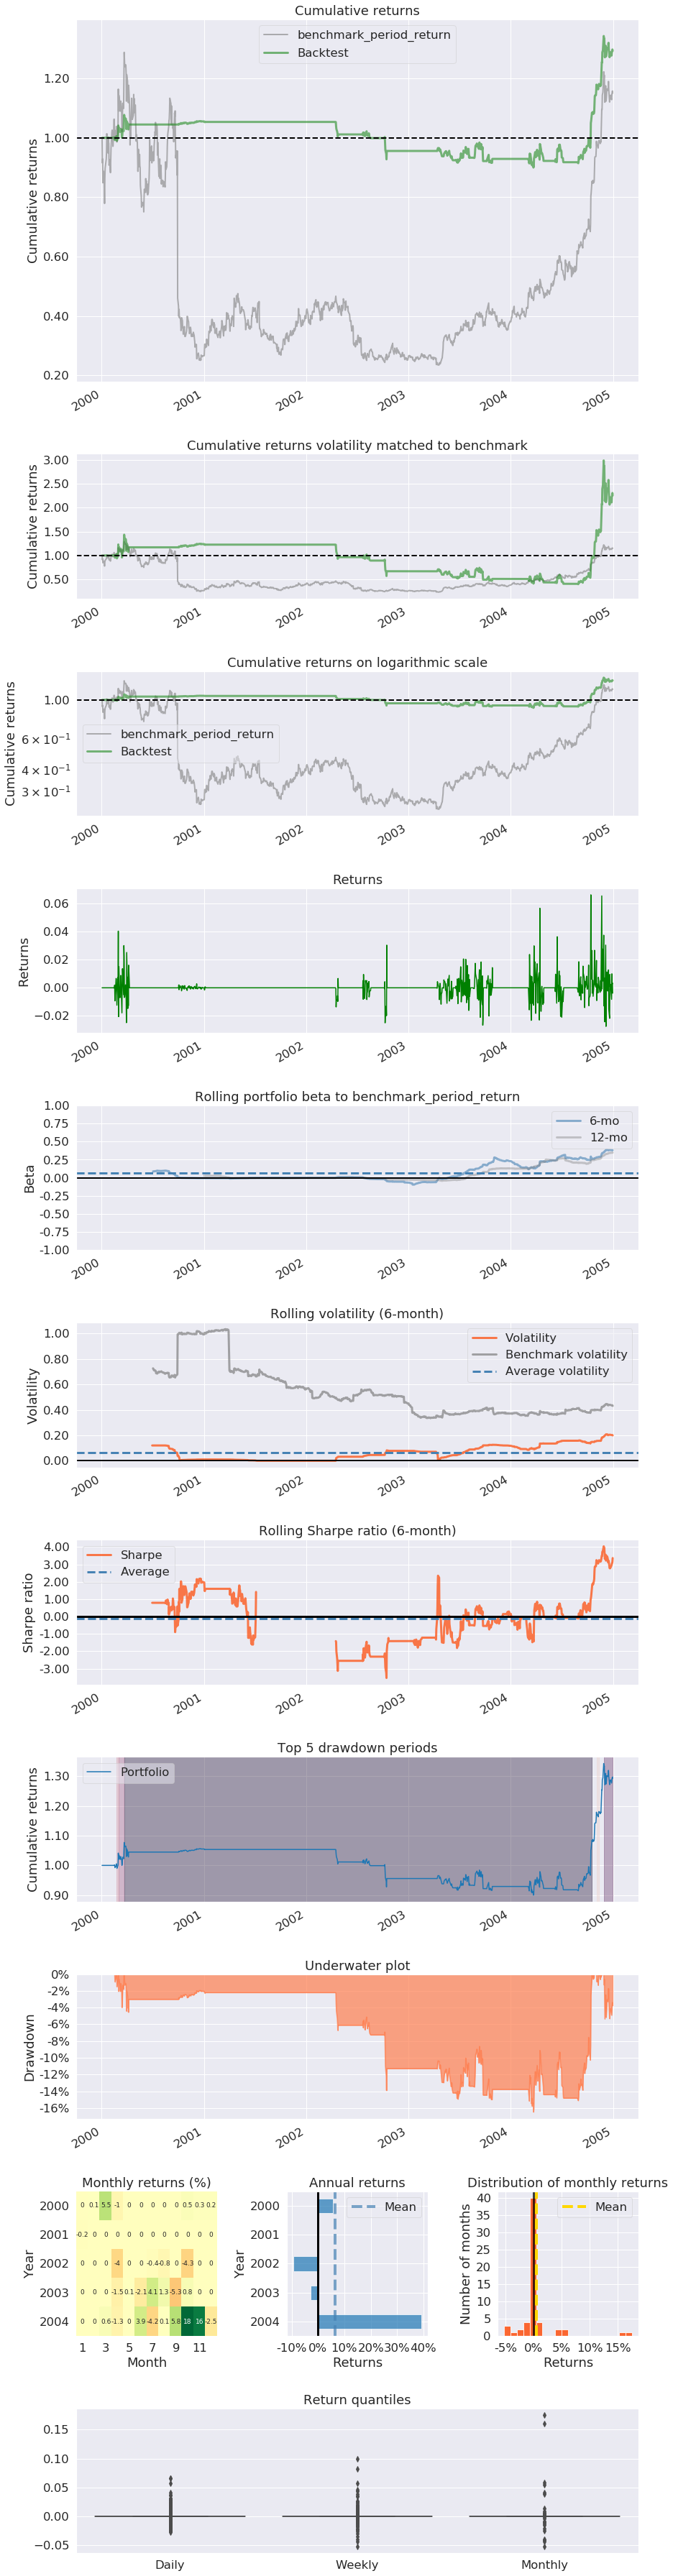

In [107]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
benchmark_period_return = perf['benchmark_period_return']
# Convert benchmark returns to daily returns
daily_benchmark_returns = np.exp(np.log(benchmark_period_return + 1.0).diff()) - 1
pf.create_returns_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=daily_benchmark_returns)

In [64]:
for i in range(len(perf)):
    try:
        print(perf.transactions[i][0]['amount'])
    except:
        print('void')

void
249
void
void
-249
void
-173
void
void
173
140
void
void
void
void
-140
179
void
void
-179
void
-201
void
201
205
void
void
void
void
-205
229
void
-229
226
-226
248
void
void
-248
void
292
void
-292
142
void
void
void
void
void
void
-142
void
void
236
void
void
void
void
void
void
-236
void
-148
148
void
-153
void
void
153
-152
void
void
void
void
152
137
void
-137
void
141
void
void
void
void
-141
-190
void
void
void
void
void
190
void
-220
void
void
void
void
void
void
void
void
void
void
void
220
259
void
void
void
void
void
-259
297
-297
void
-344
344
546
void
void
-546
401
void
void
-401
344
void
void
-344
435
void
void
void
-435
575
void
void
-575
void
-411
void
void
void
411
-356
void
void
void
void
void
void
void
void
void
void
void
void
356
767
void
void
void
void
void
void
void
void
void
void
void
void
-767
504
void
-504
-442
void
void
void
442
void
407
-407
-361
void
void
void
361
-119
void
void
void
void
void
void
void
void
void
119
-882
void
void
void
void
882
-956
v